# Imports

In [13]:
from load_configs import openai_api_key
from langchain_openai import OpenAI, ChatOpenAI
from typing import (
    List, Sequence, Tuple, Callable, Optional, Union, Literal,
    TYPE_CHECKING, Any, Annotated
)
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

# Model

In [9]:
chatmodel = ChatOpenAI(api_key=openai_api_key.get_secret_value(), 
                       model="gpt-4o-mini")
chatmodel.invoke("hi")

AIMessage(content='Hello! How can I assist you today?', response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_48196bc67a', 'finish_reason': 'stop', 'logprobs': None}, id='run-a4b456ac-1360-40a7-a29d-535283f57514-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17})

# State as TypedDict

In [26]:
class State(TypedDict):
    messages: Annotated[list, add_messages]  ## The messages key is annotated with the add_messages reducer function, which tells LangGraph to append new messages to the existing list, rather than overwriting it.

s1 = State()
print(s1)

### This dictionary must have a key messages with a value that is a list. 
###Type checkers (like mypy) will enforce this structure.

state_instance: State = {
    "messages": ["Hello", "World"]  
}
print(state_instance) 

## This will raise an error in static type checking tools
state_instance: State = {
    "key_out_side_of_schema": "value not in schema will raise an error by type checking tool"  
    }
print(state_instance)


{}
{'messages': ['Hello', 'World']}
{'key_out_side_of_schema': 'value not in schema will raise an error by type checking tool'}


# StateGraph Graph Builder

In [28]:
graph_builder = StateGraph(State)
##graph_builder has methods to add node , edge 

In [33]:
## create a chatbot node - 
### Every node will receive current state as input and return updated state
def chatbot(state: State):
    node_input = state["messages"]
    node_result = chatmodel.invoke(node_input)
    node_output = {"messages": [node_result]}
    return node_output
try:
    graph_builder.add_node("chatbot", chatbot)
except:
    pass
print(graph_builder.nodes)

{'chatbot': StateNodeSpec(runnable=chatbot(recurse=True), metadata=None, input=<class '__main__.State'>, retry_policy=None)}

In [35]:
graph_builder.add_edge(START, "chatbot") ## ENTRY POINT
graph_builder.add_edge("chatbot", END) ### finish point
graph = graph_builder.compile()
graph

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


CompiledStateGraph(nodes={'__start__': PregelNode(config={'tags': ['langsmith:hidden'], 'metadata': {}, 'configurable': {}}, channels=['__start__'], triggers=['__start__'], writers=[ChannelWrite<messages>(recurse=True, writes=[ChannelWriteEntry(channel='messages', value=<object object at 0x7f97660fddf0>, skip_none=False, mapper=_get_state_key(recurse=False))], require_at_least_one_of=['messages']), ChannelWrite<start:chatbot>(recurse=True, writes=[ChannelWriteEntry(channel='start:chatbot', value='__start__', skip_none=False, mapper=None)], require_at_least_one_of=None)]), 'chatbot': PregelNode(config={'tags': [], 'metadata': {}, 'configurable': {}}, channels={'messages': 'messages'}, triggers=['start:chatbot'], mapper=functools.partial(<function _coerce_state at 0x7f9765d2a4c0>, <class '__main__.State'>), writers=[ChannelWrite<chatbot,messages>(recurse=True, writes=[ChannelWriteEntry(channel='chatbot', value='chatbot', skip_none=False, mapper=None), ChannelWriteEntry(channel='messages'

In [38]:
graph.get_graph()

Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=<class 'pydantic.v1.main.LangGraphInput'>, metadata=None), 'chatbot': Node(id='chatbot', name='chatbot', data=chatbot(recurse=True), metadata=None), '__end__': Node(id='__end__', name='__end__', data=<class 'pydantic.v1.main.LangGraphOutput'>, metadata=None)}, edges=[Edge(source='__start__', target='chatbot', data=None, conditional=False), Edge(source='chatbot', target='__end__', data=None, conditional=False)])

In [41]:
print(graph.get_graph().draw_mermaid())

%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__([__start__]):::first
	chatbot(chatbot)
	__end__([__end__]):::last
	__start__ --> chatbot;
	chatbot --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



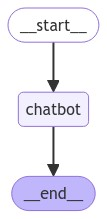

In [37]:
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    pass

In [60]:
input_state = {"messages": ("user", "tell me a one line poem on early morning")}
streamed_output_state_from_graph = graph.stream(input_state)
print('streamed_output_state_from_graph type:', type(streamed_output_state_from_graph))
output_state_from_graph = next(streamed_output_state_from_graph)
print('output_state_from_graph:', output_state_from_graph)

streamed_output_state_from_graph type: <class 'generator'>
output_state_from_graph: {'chatbot': {'messages': [AIMessage(content="In dawn's soft whisper, dreams dissolve like mist.", response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 16, 'total_tokens': 27}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_48196bc67a', 'finish_reason': 'stop', 'logprobs': None}, id='run-cc859b56-ea08-41de-9a3d-445f10de4c14-0', usage_metadata={'input_tokens': 16, 'output_tokens': 11, 'total_tokens': 27})]}}


In [65]:
chatmodel_output = output_state_from_graph['chatbot']['messages'][0]
print(chatmodel_output.content)
print(chatmodel_output.usage_metadata)
print(chatmodel_output.response_metadata)

In dawn's soft whisper, dreams dissolve like mist.
{'input_tokens': 16, 'output_tokens': 11, 'total_tokens': 27}
{'token_usage': {'completion_tokens': 11, 'prompt_tokens': 16, 'total_tokens': 27}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_48196bc67a', 'finish_reason': 'stop', 'logprobs': None}


In [50]:
for event in events:
    for value in event.values():
        print("Assistant:", value["messages"][-1].content)

Assistant: In the hush of dawn, the world whispers new dreams.
